# Prestack Fracture Parameters Detection by HDNN Model
Description
- Author: Zhenyu Yuan
- Email: zhenyuyuan@outlook.com
- Function: prestack fracture detection by hybrid deep neural network

This work includes three parts:
- Data set preparation
- Model training

This implementation of deep learning is referred to [Keras: Multiple Inputs and Mixed Data](https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/)

Model Training and visulization is referred to [Regression: predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/basic_regression)

## Data set preparation

### Load raw data to working directory

For the implementation in colab, raw data are stored in my dirve, which need to be mounted to working directory.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
dpath = '/gdrive/My Drive/ML_Dataset/Qingchengbei'

Read well-production information into DataFrame and do some analysis

In [ ]:
import os
import sys

In [ ]:
sys.path.insert(0,'/gdrive/My Drive/Pythons/py_basics')

In [ ]:
import utils

In [ ]:
import random
import math
import statistics

In [ ]:
try:
    from ellipse import LsqEllipse
except ImportError:
    !pip install lsq-ellipse
    from ellipse import LsqEllipse

In [ ]:
figpath=os.path.join(dpath,'figure')
os.makedirs(figpath, exist_ok=True)

In [ ]:
import pandas as pd
print('Pandas Version: ', pd.__version__)
import numpy as np
print('Numpy Version: ', np.__version__)
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

Pandas Version:  1.1.5
Numpy Version:  1.19.5


#### Read data from files

In [ ]:
mldpath = './mldata'
os.makedirs(mldpath, exist_ok=True)

In [ ]:
import zipfile

zip_name = os.path.join(dpath, 'mldata.zip')
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(mldpath)

In [ ]:
# function to prepare log curves
def prepare_mldata(path,elist,dlist,alist,wlist,nrow=8):
    '''

    return xdata and ydata
    '''
    xlist=list()
    ylist=list()
    errflist=list()
    for e in elist:
        for d in dlist:
            for a in alist:
                dirname = 'e{}_d{}_a{}'.format(e,d,a)
                for w in wlist:
                    fname = os.path.join(path, dirname, w)#'{}.mat'.format(w)
                    try:
                        idata = list(sio.loadmat(fname).values())[-1] # last index is the valid data
                    except FileNotFoundError:
                        errflist.append(fname)
                        continue
                    # extract data by nrow
                    ns = idata.shape[0]//nrow*nrow # make sure the row number is multiple of 8
                    idata = idata[:ns,:]
                    idata = idata[None,...]
                    idata = idata.reshape(-1,nrow,idata.shape[-1])
                    xlist.append(idata)
                    # prepare label
                    ilabel = np.array([e,d,a]).reshape(1,3)
                    ylist.append(np.repeat(ilabel,idata.shape[0],axis=0))

    return np.vstack(xlist), np.vstack(ylist), errflist

In [ ]:
elist = [0,0.05,0.1,0.2] #[0,0.01,0.05,0.1,0.2]
dlist = list(range(40,100,10)) #list(range(50,100,10))
alist = list(range(0,180,10))

In [ ]:
dlist

[40, 50, 60, 70, 80, 90]

In [ ]:
# set well list, [NOTE] need update, or by other methods
wlist = ['Baib117','Baib439','Cai30','Cai31','Cai32','Cai38','Cheng73','Cheng75','Cheng78','Li130','Li134','Li142','Li143']

In [ ]:
# get ml data
xdata,ydata_init,errlist=prepare_mldata(mldpath,elist,dlist,alist,wlist[:])

In [ ]:
ydata = ydata_init

In [ ]:
np.unique(ydata_init[:,1])

array([40., 50., 60., 70., 80., 90.])

#### Preparation of azimuths

- set azimuth data with size (1*6)

In [ ]:
# prepare azimuth data
xazi = np.arange(15,180,30)
xazi = xazi.reshape(1,-1,xazi.size)
xazi = np.repeat(xazi, xdata.shape[0], axis=0)
xazi.shape

(45792, 1, 6)

### Samples Visualization

In [ ]:
def plotsamples(xdata,ydata,nrow=4,ncol=8,figsize=(15,10),cmap='hot',fname=''):
    fig,axs = plt.subplots(nrow,ncol,figsize=figsize)
    for i in range(nrow):
        for j in range(ncol):
            idx = random.randint(0,xdata.shape[0])
            axs[i,j].imshow(xdata[idx,...],cmap=cmap)
            # axs[i,j].set_xlabel(str(ydata[idx]),fontweight='bold')
            axs[i,j].get_xaxis().set_ticks([])
            axs[i,j].get_yaxis().set_ticks([])

    plt.show()
    if fname:
        fig.savefig(fname, bbox_inches='tight')


### Ellipse fitting
- perform ellipse fitting and put into network

In [ ]:
from matplotlib.patches import Ellipse
def ellipsefit(X1,X2):
    X = np.array(list(zip(X1, X2)))
    reg = LsqEllipse().fit(X)
    center, width, height, phi = reg.as_parameters()

    print(f'center: {center[0]:.3f}, {center[1]:.3f}')
    print(f'width: {width:.3f}')
    print(f'height: {height:.3f}')
    print(f'phi: {phi:.3f}')

    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    ax.axis('equal')
    ax.plot(X1, X2, 'ro', zorder=1)
    ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )
    ax.add_patch(ellipse)

    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')

    plt.legend()
    plt.show()
    return reg

In [ ]:
def fitphi2azi(width, height, phi, dgr=True):
    if width>=height:
        if phi<0:
            phi = np.pi + phi
    elif width<height:
        phi = np.pi/2 + phi

    if dgr:
        return np.rad2deg(phi)
    else:
        return phi

In [ ]:
## Note: math functions can be replaced by numpy function
def polar2xy(ang, r):
    ## input 1D array need to be flattened
    x = np.zeros_like(r)
    y = np.zeros_like(r)
    for i in range(ang.size):
        #convert angle to radian
        # rad = ang * math.pi / 180
        rad = math.radians(ang[i])
        x[i] = r[i]*math.cos(rad)
        y[i] = r[i]*math.sin(rad)
        # print(rad,r[i],x[i],y[i])
    return x, y

### Machine learning data preparation

#### Feature preparation of azimuthal impedance

- data normalization to（0,1）

In [ ]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
def samplescale(samp,vmin=0,limit=(0,1)):
    tmp = samp
    rmin, rmax = limit
    for i in range(samp.shape[0]):
        vmax = np.amax(samp[i])
        tmp[i,:] = rmin + (rmax-rmin) * (samp[i,:]-vmin) / (vmax-vmin)
    return tmp

def datascale(indata):
    xdatanorm = np.copy(indata)
    for i in range(indata.shape[0]):
        xdatanorm[i,...] = samplescale(xdatanorm[i,...])
    return xdatanorm

In [ ]:
xdatanorm = datascale(xdata)

In [ ]:
xdatanorm=xdatanorm[...,np.newaxis]
xdatanorm.shape

(45792, 8, 6, 1)

#### Label preparation

- dip and azimuth binning

In [ ]:
# bin dip and azimuth
def binArray(data, bins=list(range(10,110,30)),right=False):
    # data: 1D array
    # meanlist=[statistics.mean(binlist[i:i+2]) for i in range(len(binlist)-1)]
    inds = np.digitize(data,bins,right)
    means = [data[inds == i].mean() for i in range(1, len(bins))]
    for i in range(data.size):
        data[i] = means[inds[i]-1]

In [ ]:
# bin dip to three values
binArray(ydata[:,1], list(range(40,110,20))) # list(range(10,110,30))
np.unique(ydata[:,1])

array([45., 65., 85.])

In [ ]:
# bin azimuth to six values
binArray(ydata[:,2], list(range(0,190,30)))
np.unique(ydata[:,2])

array([ 10.,  40.,  70., 100., 130., 160.])

In [ ]:
# ydata.shape

- convert values to types for classification

In [ ]:
def float2str(data):
    svec = data.astype(str)
    for i in range(data.shape[0]):
        for j in range(data.shape[-1]):
            svec[i,j] = str(data[i,j])
    return svec

In [ ]:
def str2float(tstr):
    if tstr=='None':
        return -1
    return float(tstr)

In [ ]:
ydata_str = float2str(ydata)

- set dip and azimuth as None when fracture density is 0

In [ ]:
def assignNone(data):
    idxlist = np.where(data[:,0]=='0.0')
    data[idxlist,1:] = None
    return idxlist

In [ ]:
idxlist=assignNone(ydata_str)
idxlist

(array([    0,     1,     2, ..., 11445, 11446, 11447]),)

- convert ydata from string to label binarizer

In [ ]:
# convert ydata from string to label binarizer
from sklearn.preprocessing import LabelBinarizer
def initlabelbinarizer(strArray):
    lb = LabelBinarizer()
    lb.fit(strArray)
    return lb

def strcat2labelbinarizer(ylabel):
    lblist=list()
    ycat =list()

    for i in range(ylabel.shape[-1]):
        labelb = LabelBinarizer()
        ycat.append(labelb.fit_transform(ylabel[:,i]))
        lblist.append(labelb)
    return ycat, lblist

def strcat2label(lblist, ylabel):
    # the column number of ylabel equal to length of lblist
    outlist = list()
    for i in range(lblist):
        outlist.append(lblist[i].transform(ylabel[:,i]))
    return outlist

In [ ]:
ycat, lblist = strcat2labelbinarizer(ydata_str)
ycat_e,ycat_d,ycat_a=ycat

#### split train and test data

In [ ]:
 # split train and test data
 from sklearn.model_selection import train_test_split
 xdata_train, xdata_test, xazi_train, xazi_test, y_train, y_test, ye_train, ye_test, yd_train, yd_test, ya_train, ya_test = train_test_split(
     xdatanorm, xazi, ydata, ycat_e, ycat_d, ycat_a, test_size=0.2, random_state=1)

#### Prepare ellipse fitting data

In [ ]:
def prepareEllipseData(dgrdata, rdata):
    def _relativeanisotropy(width, height):
        return (max(width,height) - min(width,height))/max(width,height)

    outlist = list()
    for idx in range(dgrdata.shape[0]):
        ang = dgrdata[idx]
        r = rdata[idx].squeeze()
        # convert polar to x y
        X1,X2 = polar2xy(ang.flatten(),np.average(r,0).flatten())
        X = np.array(list(zip(X1, X2)))
        reg = LsqEllipse().fit(X)
        center, width, height, phi = reg.as_parameters()
        phi = fitphi2azi(width, height, phi)
        ani = _relativeanisotropy(width, height)
        para = [center[0],center[1],width,height,ani,phi]
        outlist.append(para)

    return np.array(outlist)

In [ ]:
xellip_train = prepareEllipseData(xazi_train, xdata_train)

In [ ]:
xellip_test = prepareEllipseData(xazi_test, xdata_test)

## Deep Learning

### Basic functions

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Concatenate, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
        # print('')
        print(epoch//100, end='->')
    # print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def plot_history(history, fname=''):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch', fontweight='bold')
  plt.ylabel('Mean Abs Error', fontweight='bold')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['mean_squared_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
# #   plt.ylim([0,20])
#   plt.legend()
#   plt.show()

  if fname is not None and type(fname) is str:
    plt.savefig(fname, dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Plot and comparison
def plot_cmp(x, y, fname='', minv=None, maxv=None):
    # plot scatter
    plt.figure(figsize=(6,6))
    plt.scatter(x,y,c='blue',s=50)
    if minv is None:
        minv=math.floor((min(x.min(), y.min())-1)/5)*5
    if maxv is None:
        maxv=math.ceil((max(x.max(), y.max())+10)/5)*5
    plt.xlim(minv,maxv)
    plt.ylim(minv,maxv)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(np.arange(minv, maxv+1, 100))
    plt.yticks(np.arange(minv, maxv+1, 100))

    # plot labels
    plt.xlabel('Real Production (t/d)', fontweight='bold')
    plt.ylabel('Prdt Production (t/d)', fontweight='bold')

    # plot diagonal line
    plt.plot([minv,maxv,1],[minv,maxv,1],c='red')

    dv = maxv - minv
    # # plot explained_variance_score value
    # var = explained_variance_score(x,y)
    # plt.text(minv+dv/10,maxv-dv/10, r'var = ' + '%3.2f' % var, fontweight='bold')

    # plot scc value
    scc = r2_score(x,y)
    # plt.text(minv+dv/10,maxv-dv/10, r'r$^2$ = ' + '%3.2f' % scc, fontweight='bold')
    mae = mean_absolute_error(x,y)
    # plt.text(minv+dv/10,maxv-dv/8, 'Mean Abs Error = ' + '%3.2f;\n' % mae + r'r$^2$ = ' + '%3.2f' % scc, fontweight='bold')
    plt.text(minv+dv/10,maxv-dv/10, 'Mean Abs Error = ' + '%3.2f' % mae, fontweight='bold')

    if fname is not None and type(fname) is str:
        plt.savefig(fname, dpi=300, bbox_inches='tight')

### Define model

In [ ]:
class CNNMLModel(object):
    def __init__(self,xdata_shape,xazi_shape,xellip_dim,y_dim,cat_dim,cat_label):
        self.shape_xdata = xdata_shape # shape of input azimuth data
        self.shape_xazi = xazi_shape # shape of input azimuth value
        self.elp_dim = xellip_dim
        self.out_dim = y_dim
        self.cat_dim = cat_dim
        self.cat_label = cat_label

    def block_cnn2d(self, inputs, klist=[4,8,1]):
        # inputs = Input(shape=self.shape_xdata)
        layer = len(klist)
        if layer==2:
            # 8*6 to 2*6
            x = Conv2D(klist[0],3, strides=(2,1),padding='same')(inputs)
            x = Activation('relu')(x)
            x = BatchNormalization(momentum=0.9)(x)
            x = Dropout(0.4)(x)
            x = MaxPooling2D(2,(2,1),padding='same')(x)
        else:
            # 8*6 to 4*6
            x = Conv2D(klist[0],3,padding='same')(inputs)
            x = Activation('relu')(x)
            x = BatchNormalization(momentum=0.9)(x)
            x = Dropout(0.2)(x)
            x = MaxPooling2D(2,(2,1),padding='same')(x)

            # 4*6 to 2*6
            x = Conv2D(klist[1],2,padding='same')(x)
            x = Activation('relu')(x)
            x = BatchNormalization(momentum=0.9)(x)
            x = Dropout(0.4)(x)
            x = MaxPooling2D(2,(2,1),padding='same')(x)

        # 2*6 to 1*6
        x = Conv2D(klist[-1],2,padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = MaxPooling2D(2,(2,1),padding='same')(x)
        x = Reshape((1,6))(x)

        return x

    def block_mlp(self, inputs):
        # inputs = Input(shape=self.shape_xazi)
        return inputs

    def block_neck(self, inputs_cnn, inputs_cnn1d=None):
        if inputs_cnn1d is not None:
            cmb_input = Concatenate(axis=1)([inputs_cnn1d, inputs_cnn])
            x = Reshape((6,2))(cmb_input)
            x = Conv1D(1, 3, padding='same')(x)
            x = Activation('relu')(x)
            x = BatchNormalization(momentum=0.9)(x)
        else:
            x = inputs_cnn

        x = Flatten()(x)
        return x

    def block_reg(self, inputs):
        x = inputs
        x = Dense(self.out_dim)(x)
        return x

    def block_cat(self, inputs, outdim, outlabel, hidenodes=None):
        x = inputs
        if hidenodes is not None:
            for node in hidenodes:
                x = Dense(node)(x)
                x = Activation('relu')(x)
                x = BatchNormalization(momentum=0.9)(x)
        x = Dense(outdim)(x)
        x = Activation('softmax',name=outlabel)(x)
        return x

    def block_cat_e(self, inputs, outdim, outlabel, basic=True):
        if basic:
            return self.block_cat(inputs, outdim, outlabel)

        x = inputs
        x = Dense(18)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = Dense(outdim)(x)
        x = Activation('softmax',name=outlabel)(x)
        return x

    def block_cat_d(self, inputs, outdim, outlabel, basic=True):
        if basic:
            return self.block_cat(inputs, outdim, outlabel)

        x = inputs
        x = Dense(18)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = Dense(outdim)(x)
        x = Activation('softmax',name=outlabel)(x)
        return x

    def block_cat_a(self, inputs, outdim, outlabel, basic=True):
        if basic:
            return self.block_cat(inputs, outdim, outlabel)

        x = inputs
        x = Dense(18)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = Dense(outdim)(x)
        x = Activation('softmax',name=outlabel)(x)
        return x

    def bulid_model(self,reg=False,summary=True,cnn1d=True,klist=[4,8,1],
                    bclist=[True, True, True],shareinput=True,outlist=None,
                    hidenodes=[12],only_ellip=False):
        cnn1d_input = None
        if cnn1d:
            cnn1d_input = Input(shape=self.shape_xazi)
        cnn_input = Input(shape=self.shape_xdata)
        dis_input = Input(shape=self.elp_dim)
        if reg:
            if only_ellip:
                x = self.block_reg(dis_input)
                model = Model(inputs=dis_input, outputs=x)
            else:
                cnn_output = self.block_cnn2d(cnn_input, klist)
                x = self.block_neck(cnn_output, cnn1d_input)
                x = self.block_reg(x)
                model = Model(inputs=[cnn1d_input, cnn_input], outputs=x)
        else:
            outlaylist=list()
            if shareinput:
                blockclist = [self.block_cat_e, self.block_cat_d, self.block_cat_a]
                for i in range(len(self.cat_label)):
                    if only_ellip:
                        x = dis_input
                    else:
                        cnn_output = self.block_cnn2d(cnn_input, klist)
                        x = self.block_neck(cnn_output, cnn1d_input)
                        x = Concatenate()([x,dis_input])
                    outlaylist.append(blockclist[i](x,self.cat_dim[i],self.cat_label[i],bclist[i]))
            else:
                if only_ellip:
                    x = dis_input
                else:
                    cnn_output = self.block_cnn2d(cnn_input, klist)
                    x = self.block_neck(cnn_output, cnn1d_input)
                    x = Concatenate()([x,dis_input])
                for i in range(len(self.cat_label)):
                    outlaylist.append(self.block_cat(x,self.cat_dim[i],self.cat_label[i],hidenodes=hidenodes))
            # output one or more
            if outlist is None:
                if only_ellip:
                    model = Model(inputs=dis_input, outputs=outlaylist)
                elif cnn1d:
                    model = Model(inputs=[cnn1d_input, cnn_input, dis_input], outputs=outlaylist)
                else:
                    model = Model(inputs=[cnn_input, dis_input], outputs=outlaylist)
            else:
                outlayer = [outlaylist[i] for i,cat in enumerate(self.cat_label) if cat in outlist]
                if only_ellip:
                    model = Model(inputs=dis_input, outputs=outlayer)
                elif cnn1d:
                    model = Model(inputs=[cnn1d_input, cnn_input, dis_input], outputs=outlayer)
                else:
                    model = Model(inputs=[cnn_input, dis_input], outputs=outlayer)

        if summary:
            model.summary()

        return model

    def compile_model(self, model, loss="mean_squared_error", opt=Adam(),
                      metrics=['mean_absolute_error', 'mean_squared_error'],**kw):
        model.compile(loss=loss, optimizer=opt, metrics=metrics,**kw)

    def train_model(self,model,xtrain,ytrain,weightfile,logpath,logfile,histfile,
                    epoch=200,batch=32, valRt=0.2,shuff=True,init_epoch=0,**kw):
        # callbacks
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=weightfile,verbose=1, save_best_only=True,every=kw['every'],startAt=kw['startAt'])
        earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0,patience=kw['patience'])
        csv_log = keras.callbacks.CSVLogger(logfile)
        tensboard_cb = keras.callbacks.TensorBoard(log_dir=logpath,histogram_freq=1)
        callbacks = [checkpointer,earlystopper,csv_log,tensboard_cb]
        if 'cb_no' in kw:
            if 'cp' in kw['cb_no']:
                callbacks.remove(checkpointer)
            if 'es' in kw['cb_no']:
                callbacks.remove(earlystopper)
            if 'csv' in kw['cb_no']:
                callbacks.remove(csv_log)
            if 'tb' in kw['cb_no']:
                callbacks.remove(tensboard_cb)
        # fitting
        hist = model.fit(xtrain, ytrain, batch_size=batch, epochs=epoch, shuffle=shuff,
                         callbacks=callbacks, validation_split=valRt,initial_epoch=init_epoch,
                         validation_data=kw['validation_data'])
        print('Training Finish')
        utils.save_weights(model, weightfile)
        utils.save_history(histfile, hist)
        return hist, model

    def load_model(self, weightfile):
        model = self.cnnmodel(summary=False)
        model = utils.load_weights(model, weightfile, True)
        model = utils.compile_model(model)
        return model

    def model_valid(self, model, x, y, show_idx=None):
        test_score = model.evaluate(x, y, verbose=1)
        print(test_score)
        if show_idx is not None:
            yp = model.predict(x, verbose=1)
            if show_idx<0 or show_idx>=y.shape[0]:
                show_idx = 0
            plt.scatter(y[show_idx,:],yp[show_idx,:])
            # vmin = min(min(y[show_idx,:]),min(yp[show_idx,:]))
            # vmax = max(max(y[show_idx,:]),max(yp[show_idx,:]))
            # plt.xlim(vmin,vmax)
            # plt.ylim(vmin,vmax)
            # plt.gca().set_aspect('equal', adjustable='box')
            plt.axis('square')
            plt.xlabel('Initial')
            plt.ylabel('Predict')
            plt.draw()

    def model_predict(self, model, x, verbose=0):
        y = model.predict(x, verbose=verbose)
        return y

### Model Training

In [ ]:
cat_dim=[ycat_e.shape[-1],ycat_d.shape[-1],ycat_a.shape[-1]]
cat_label=['fe_cat','fd_cat','fa_cat']
cnnmodel = CNNMLModel(xdatanorm.shape[1:],xazi.shape[1:],xellip_train.shape[-1],ydata.shape[-1],cat_dim,cat_label)

In [ ]:
xazi.shape[1:],xellip_train.shape[-1],ydata.shape[-1]

((1, 6), 6, 3)

#### Multi-output model

In [ ]:
model_cat = cnnmodel.bulid_model(reg=False,cnn1d=True,klist=[6,1],bclist=[False,False,False],shareinput=False,outlist=None,hidenodes=None)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 8, 6, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 4, 6, 6)      60          input_38[0][0]                   
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 4, 6, 6)      0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 4, 6, 6)      24          activation_56[0][0]              
___________________________________________________________________________________________

In [ ]:
version='vn-ok2'
logpath = os.path.join(dpath,'train-QCB-mix-cat-{}'.format(version))
os.makedirs(logpath, exist_ok=True)
wfile = os.path.join(logpath, 'mix-cat-epoch1000.h5')
lfile = os.path.join(logpath, 'performance.csv')
hfile = os.path.join(logpath, 'hist.pkl')

In [ ]:
opt = Adam() #Adam(lr=1e-3, decay=1e-3 / 200, amsgrad=True)
sgd = keras.optimizers.SGD(learning_rate=0.01)
loslist=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy']
metlist=['accuracy','accuracy','accuracy']
cnnmodel.compile_model(model_cat,loss=dict(zip(cat_label,loslist)),opt=opt,
                       metrics=dict(zip(cat_label,metlist)))

In [ ]:
print('Model Training ...')
# 'validation_data':([xazi_train[:2000], xdata_train[:2000]], [ye_train[:2000],yd_train[:2000],ya_train[:2000]]),
startepoch=0
kwargs={'validation_data':None,'patience':10,'every':5,'startAt':startepoch}#'cb_no':['es'],
cat_hist = cnnmodel.train_model(model_cat, xellip_train, [ye_train,yd_train,ya_train],
                                wfile,logpath,lfile,hfile,epoch=1000,valRt=0.1,initial_epoch=startepoch,**kwargs)

print('Model Training Complete!')

Model Training ...
Epoch 1/1000
1031/1031 [==============================] - 3s 2ms/step - loss: 55.1719 - fe_cat_loss: 24.7398 - fd_cat_loss: 17.5044 - fa_cat_loss: 12.9277 - fe_cat_accuracy: 0.2589 - fd_cat_accuracy: 0.3000 - fa_cat_accuracy: 0.1964 - val_loss: 3.9304 - val_fe_cat_loss: 1.2830 - val_fd_cat_loss: 1.1879 - val_fa_cat_loss: 1.4595 - val_fe_cat_accuracy: 0.3504 - val_fd_cat_accuracy: 0.4438 - val_fa_cat_accuracy: 0.3720

Epoch 00001: val_loss improved from inf to 3.93042, saving model to /gdrive/My Drive/ML_Dataset/Qingchengbei/train-QCB-mix-cat-vn-ok2/mix-cat-epoch1000.h5
Epoch 2/1000
1031/1031 [==============================] - 2s 1ms/step - loss: 3.8004 - fe_cat_loss: 1.2258 - fd_cat_loss: 1.1617 - fa_cat_loss: 1.4129 - fe_cat_accuracy: 0.4173 - fd_cat_accuracy: 0.4563 - fa_cat_accuracy: 0.4344 - val_loss: 3.4904 - val_fe_cat_loss: 1.0973 - val_fd_cat_loss: 1.0903 - val_fa_cat_loss: 1.3029 - val_fe_cat_accuracy: 0.5680 - val_fd_cat_accuracy: 0.4973 - val_fa_cat_accura

In [ ]:
cat_hist = utils.load_history(hfile)

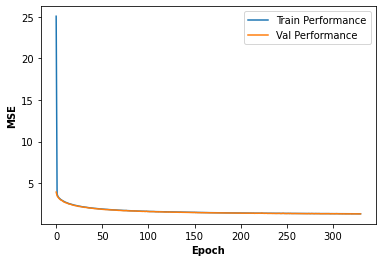

In [ ]:
utils.plot_history(cat_hist,feature='loss')

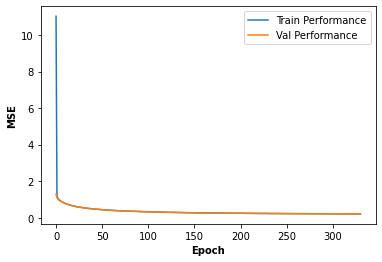

In [ ]:
utils.plot_history(cat_hist,feature='fe_cat_loss')

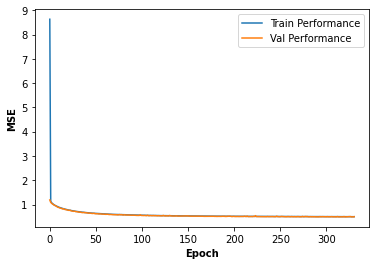

In [ ]:
utils.plot_history(cat_hist,feature='fd_cat_loss')

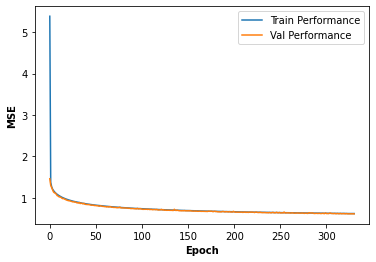

In [ ]:
utils.plot_history(cat_hist,feature='fa_cat_loss')

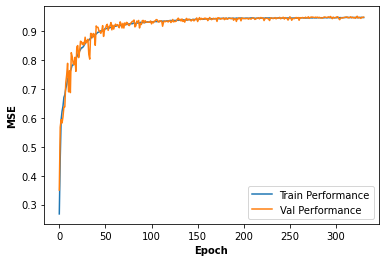

In [ ]:
utils.plot_history(cat_hist,feature='fe_cat_accuracy')

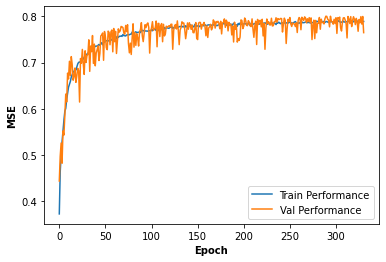

In [ ]:
utils.plot_history(cat_hist,feature='fd_cat_accuracy')

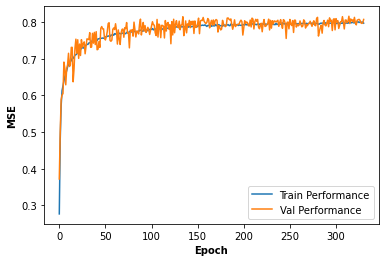

In [ ]:
utils.plot_history(cat_hist,feature='fa_cat_accuracy')

In [ ]:
utils.load_weights(model_cat, wfile)

In [ ]:
cnnmodel.model_valid(model_cat, xellip_test, [ye_test, yd_test, ya_test])

287/287 [==============================] - 0s 1ms/step - loss: 1.3082 - fe_cat_loss: 0.1973 - fd_cat_loss: 0.4933 - fa_cat_loss: 0.6176 - fe_cat_accuracy: 0.9533 - fd_cat_accuracy: 0.7749 - fa_cat_accuracy: 0.8071
[1.3082083463668823, 0.19732312858104706, 0.4932868480682373, 0.617598295211792, 0.9532700181007385, 0.7748662233352661, 0.807075023651123]


In [ ]:
ye_prdt, yd_prdt, ya_prdt = model_cat.predict(xellip_test)

In [ ]:
ye_cat = lblist[0].inverse_transform(ye_prdt)
ye_lbl = lblist[0].inverse_transform(ye_test)
cm=confusion_matrix(ye_lbl, ye_cat)
accuracy_score(ye_lbl, ye_cat)

0.9532700076427557

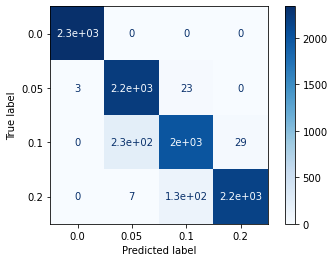

In [ ]:
fig, ax = plt.subplots()#figsize=(4, 4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lblist[0].classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
fig.savefig(os.path.join(figpath,'model-ok-cm-fe.svg'), dpi=300, bbox_inches='tight')

In [ ]:
yd_cat = lblist[1].inverse_transform(yd_prdt)
yd_lbl = lblist[1].inverse_transform(yd_test)
cm=confusion_matrix(yd_lbl, yd_cat)
accuracy_score(yd_lbl, yd_cat)

0.7748662517742112

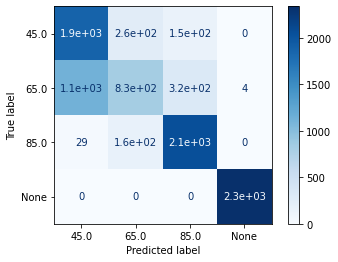

In [ ]:
fig, ax = plt.subplots()#figsize=(4, 4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lblist[1].classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
fig.savefig(os.path.join(figpath,'model-ok-cm-fd.svg'), dpi=300, bbox_inches='tight')

In [ ]:
ya_cat = lblist[2].inverse_transform(ya_prdt)
ya_lbl = lblist[2].inverse_transform(ya_test)
cm=confusion_matrix(ya_lbl, ya_cat)
accuracy_score(ya_lbl, ya_cat)

0.8070750081886668

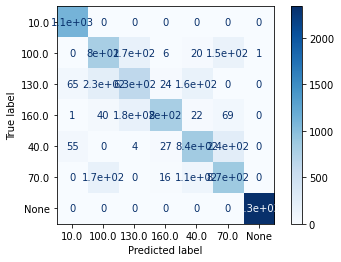

In [ ]:
fig, ax = plt.subplots()#figsize=(4, 4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lblist[2].classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
fig.savefig(os.path.join(figpath,'model-ok-cm-fa.svg'), dpi=300, bbox_inches='tight')